In [1]:
import sys
print(sys.executable)

/data/leuven/351/vsc35109/miniconda3/envs/total-env/bin/python


In [2]:
import tempfile
import muon
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import scanpy as sc
import scvi
import seaborn as sns
import torch

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Seed set to 0


Last run with scvi-tools version: 1.2.0


In [3]:
adata_rna = ad.read_h5ad("/scratch/leuven/351/vsc35109/Chen_data/Chen-2019-RNA.h5ad")
adata_atac = ad.read_h5ad("/scratch/leuven/351/vsc35109/Chen_data/Chen-2019-ATAC.h5ad")

In [4]:
import pandas as pd
adata_rna.obs.index = adata_rna.obs.index.str.replace('_RNA', '', regex=False)

In [5]:
adata_rna.obs

,domain,cell_type
cells,,
09L_GTTAGAACAGAT,scRNA-seq,E6Tle4
09I_CATAGCTCAACG,scRNA-seq,E2Rasgrf2
09G_TTACAGGCAGGT,scRNA-seq,InP
09B_CTATGGGCGTGC,scRNA-seq,E4Il1rapl2
09L_AGTGATTGTTCG,scRNA-seq,Peri
...,...,...
09E_CCTGCTCGTCAC,scRNA-seq,Peri
09E_TGAGCACCTCCT,scRNA-seq,E5Parm1
09E_CCGGACTCGATC,scRNA-seq,E3Rorb


In [6]:
adata_atac.obs.index = adata_atac.obs.index.str.replace('_ATAC', '', regex=False)
adata_atac.obs

,domain,cell_type
cells,,
09L_GTAAACCCGATA,scATAC-seq,E2Rasgrf2
09D_GCCGGGCGGCCG,scATAC-seq,E4Thsd7a
09J_TAGGCCTGAATT,scATAC-seq,E2Rasgrf2
09C_TCCGGCATCTCA,scATAC-seq,E6Tle4
09C_AGGCCACGTACA,scATAC-seq,E2Rasgrf2
...,...,...
09H_GTTTACCTAGTT,scATAC-seq,InP
09F_TAGTTGGCAGAT,scATAC-seq,E3Rorb
09L_CTTAGACGTCTA,scATAC-seq,E6Tle4


In [7]:
adata_mvi = ad.concat([adata_rna, adata_atac], join="outer", axis=1, label="modality")

In [8]:
adata_mvi

AnnData object with n_obs × n_vars = 9219 × 270687
    var: 'modality'

In [9]:
adata_mvi.obs['cell_type'] = adata_rna.obs['cell_type'] #Cell types based on rna file

In [10]:
adata_mvi.obs

,cell_type
cells,
09A_AAACCAACGCCT,E4Thsd7a
09A_AAACGTAGACAC,E3Rorb
09A_AAAGAATCCGTT,OliM
09A_AAAGGGATTCCT,InP
09A_AAAGTAAAAGGA,E4Il1rapl2
...,...
09L_TTTCCGATTCCG,E5Galnt14
09L_TTTGAACTAAGG,E2Rasgrf2
09L_TTTTACCGATAT,E5Tshz2


In [11]:
adata_mvi

AnnData object with n_obs × n_vars = 9219 × 270687
    obs: 'cell_type'
    var: 'modality'

In [12]:
adata_mvi.var

,modality
0610005C13Rik,0
0610009B22Rik,0
0610009E02Rik,0
0610009L18Rik,0
0610010F05Rik,0
...,...
chrY:1086239-1086779,1
chrY:1090474-1090713,1
chrY:1232696-1232955,1
chrY:1245435-1245988,1


In [13]:
scvi.model.MULTIVI.setup_anndata(adata_mvi)

In [14]:
model = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var["modality"] == "0").sum(),
    n_regions=(adata_mvi.var["modality"] == "1").sum(),
)
model.view_anndata_setup()

/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Anndata setup with scvi-tools version 1.2.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  9219  │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 270687 │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

In [15]:
model.train()

/tmp/ipykernel_746186/1676823408.py:1: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train()
/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/scvi/model/_multivi.py:343: UserWarning: Disabling adversarial classifier.
  training_plan = self._training_plan_cls(self.module, **plan_kwargs)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 14630.028. Signaling Trainer to stop.


In [16]:
model.save("trained_chen")

In [17]:
MULTIVI_LATENT_KEY = "X_multivi"

adata_mvi.obsm[MULTIVI_LATENT_KEY] = model.get_latent_representation()
#adata_mvi.write("/scratch/leuven/351/vsc35109/Chen_data/Chen_multiVI.h5ad")

In [18]:
adata_mvi.obsm["X_multivi"]

array([[ 5.36478385e-02,  4.17470247e-01,  5.21981250e-03, ...,
         1.66534770e+00,  8.08099508e-01, -1.37144566e+00],
       [-9.63936001e-02,  1.98232055e-01,  2.17185855e+00, ...,
         1.27458763e+00,  4.39551443e-01, -2.94202864e-01],
       [-5.17237663e-01,  3.71884465e-01,  9.01597887e-02, ...,
        -1.21882463e+00, -6.43358588e-01,  3.17493975e-01],
       ...,
       [ 1.62831880e-03, -3.08867902e-01, -1.95245314e+00, ...,
         2.66812265e-01,  2.00749278e+00,  1.13564885e+00],
       [-5.26894450e-01, -3.92618001e-01, -1.62575209e+00, ...,
        -4.88281608e-01,  6.26938999e-01,  3.45834076e-01],
       [-2.30304182e-01,  1.12113565e-01, -1.71035802e+00, ...,
        -7.77743459e-02,  1.47983149e-01,  1.85408205e-01]], dtype=float32)

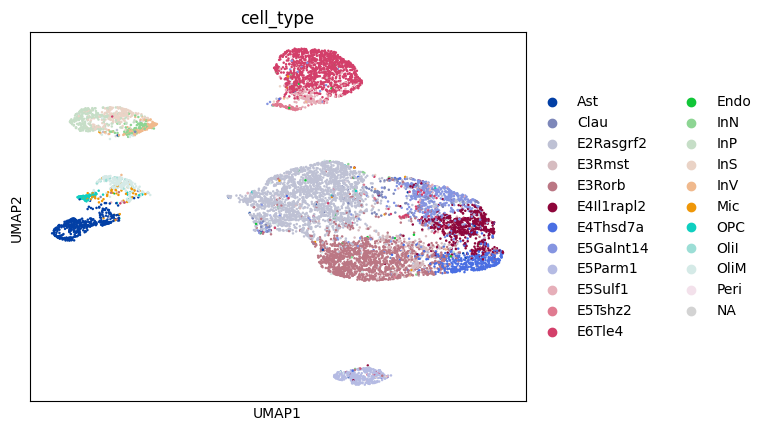

In [21]:
sc.pp.neighbors(adata_mvi, use_rep=MULTIVI_LATENT_KEY)
sc.tl.umap(adata_mvi, min_dist=0.2)
sc.pl.umap(adata_mvi, color="cell_type", save="_CHEN.png")

/tmp/ipykernel_746186/993076990.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_mvi)


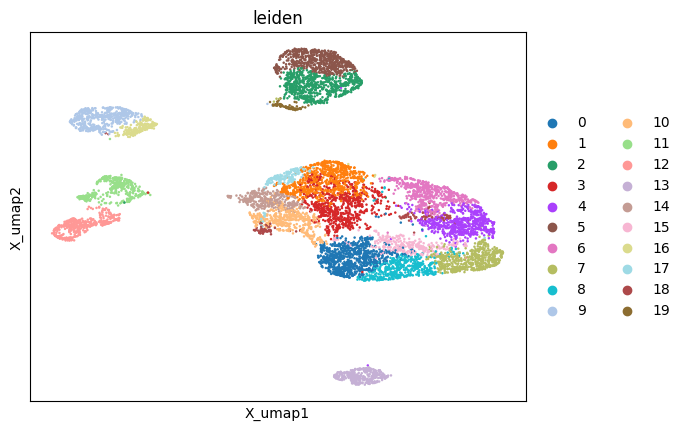

In [23]:
import leidenalg
sc.tl.leiden(adata_mvi)
sc.pl.embedding(adata_mvi, "X_umap", color=['leiden'], save="_CHEN.png")